In [1]:
%run ../supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



We walk through a Resnet50 based Variational AutoEncoder on the Trees dataset consisting of Oak and Weeping Willow trees.

First the imports

In [2]:

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from svlearn.config.configuration import ConfigurationMixin
from svlearn.trees.preprocess import Preprocessor
from svlearn.trees.tree_dataset import TreeDataset
from svlearn.auto_encoders.auto_encoder_multi_channel_util import visualize_reconstruction
                                                        
from svlearn.auto_encoders.resnet_variational_auto_encoder_modified import ResNetVariationalAutoEncoderModified
from svlearn.auto_encoders.auto_encoder_util import visualize_interpolations

In [3]:
import gc
gc.collect()
torch.cuda.empty_cache()

Load the config and paths for the tree images

In [4]:
config = ConfigurationMixin().load_config()
data_dir = config['tree-classification']['data']
results_dir = config['tree-classification']['results']

/home/chandar/ai-intro/docs/notebooks/auto_encoders


Preprocess the images as before

In [5]:
preprocessor = Preprocessor()
train_df, val_df, label_encoder = preprocessor.preprocess(data_dir)

Take them through the same tensor transforms as before

In [6]:
# 
train_transform = v2.Compose([
    v2.ToImage(), 
    v2.RandomResizedCrop(224 , scale = (0.5, 1)), # Randomly crop and resize to 224x224
    v2.RandomHorizontalFlip(p=0.5),       # Randomly flip the image horizontally with a 50% chance
    v2.ColorJitter(brightness=0.4 , contrast=0.4, saturation=0.4), # randomly change the brightness , contrast and saturation of images
    v2.ToDtype(torch.float32, scale=True), # ensure te tensor is of float datatype
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize tensor 
    
])

test_transform = v2.Compose([
    v2.ToImage(), 
    v2.Resize(size=(224 , 224)),  # resize all images to a standard size suitable for the cnn model
    v2.ToDtype(torch.float32, scale=True), # ensure te tensor is of float datatype
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize tensor 
])


Create the dataset and dataloaders

In [7]:
train_dataset = TreeDataset(train_df, transform=train_transform)
val_dataset = TreeDataset(val_df, transform=test_transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False) 

Identify device (either cuda or cpu)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNetVariationalAutoEncoderModified().to(device)

Run evaluation on the resnet50 autoencoder

In [10]:
checkpoint = torch.load(f"{results_dir}/trees_resnet50_variational_autoencoder_modified.pt")


In [11]:
print(f"Final Training loss: {checkpoint['results']['train loss'][-1]}")
print(f"Final Val loss: {checkpoint['results']['val loss'][-1]}")

Final Training loss: 20279.738695466116
Final Val loss: 22587.1826171875


Plotting training losses


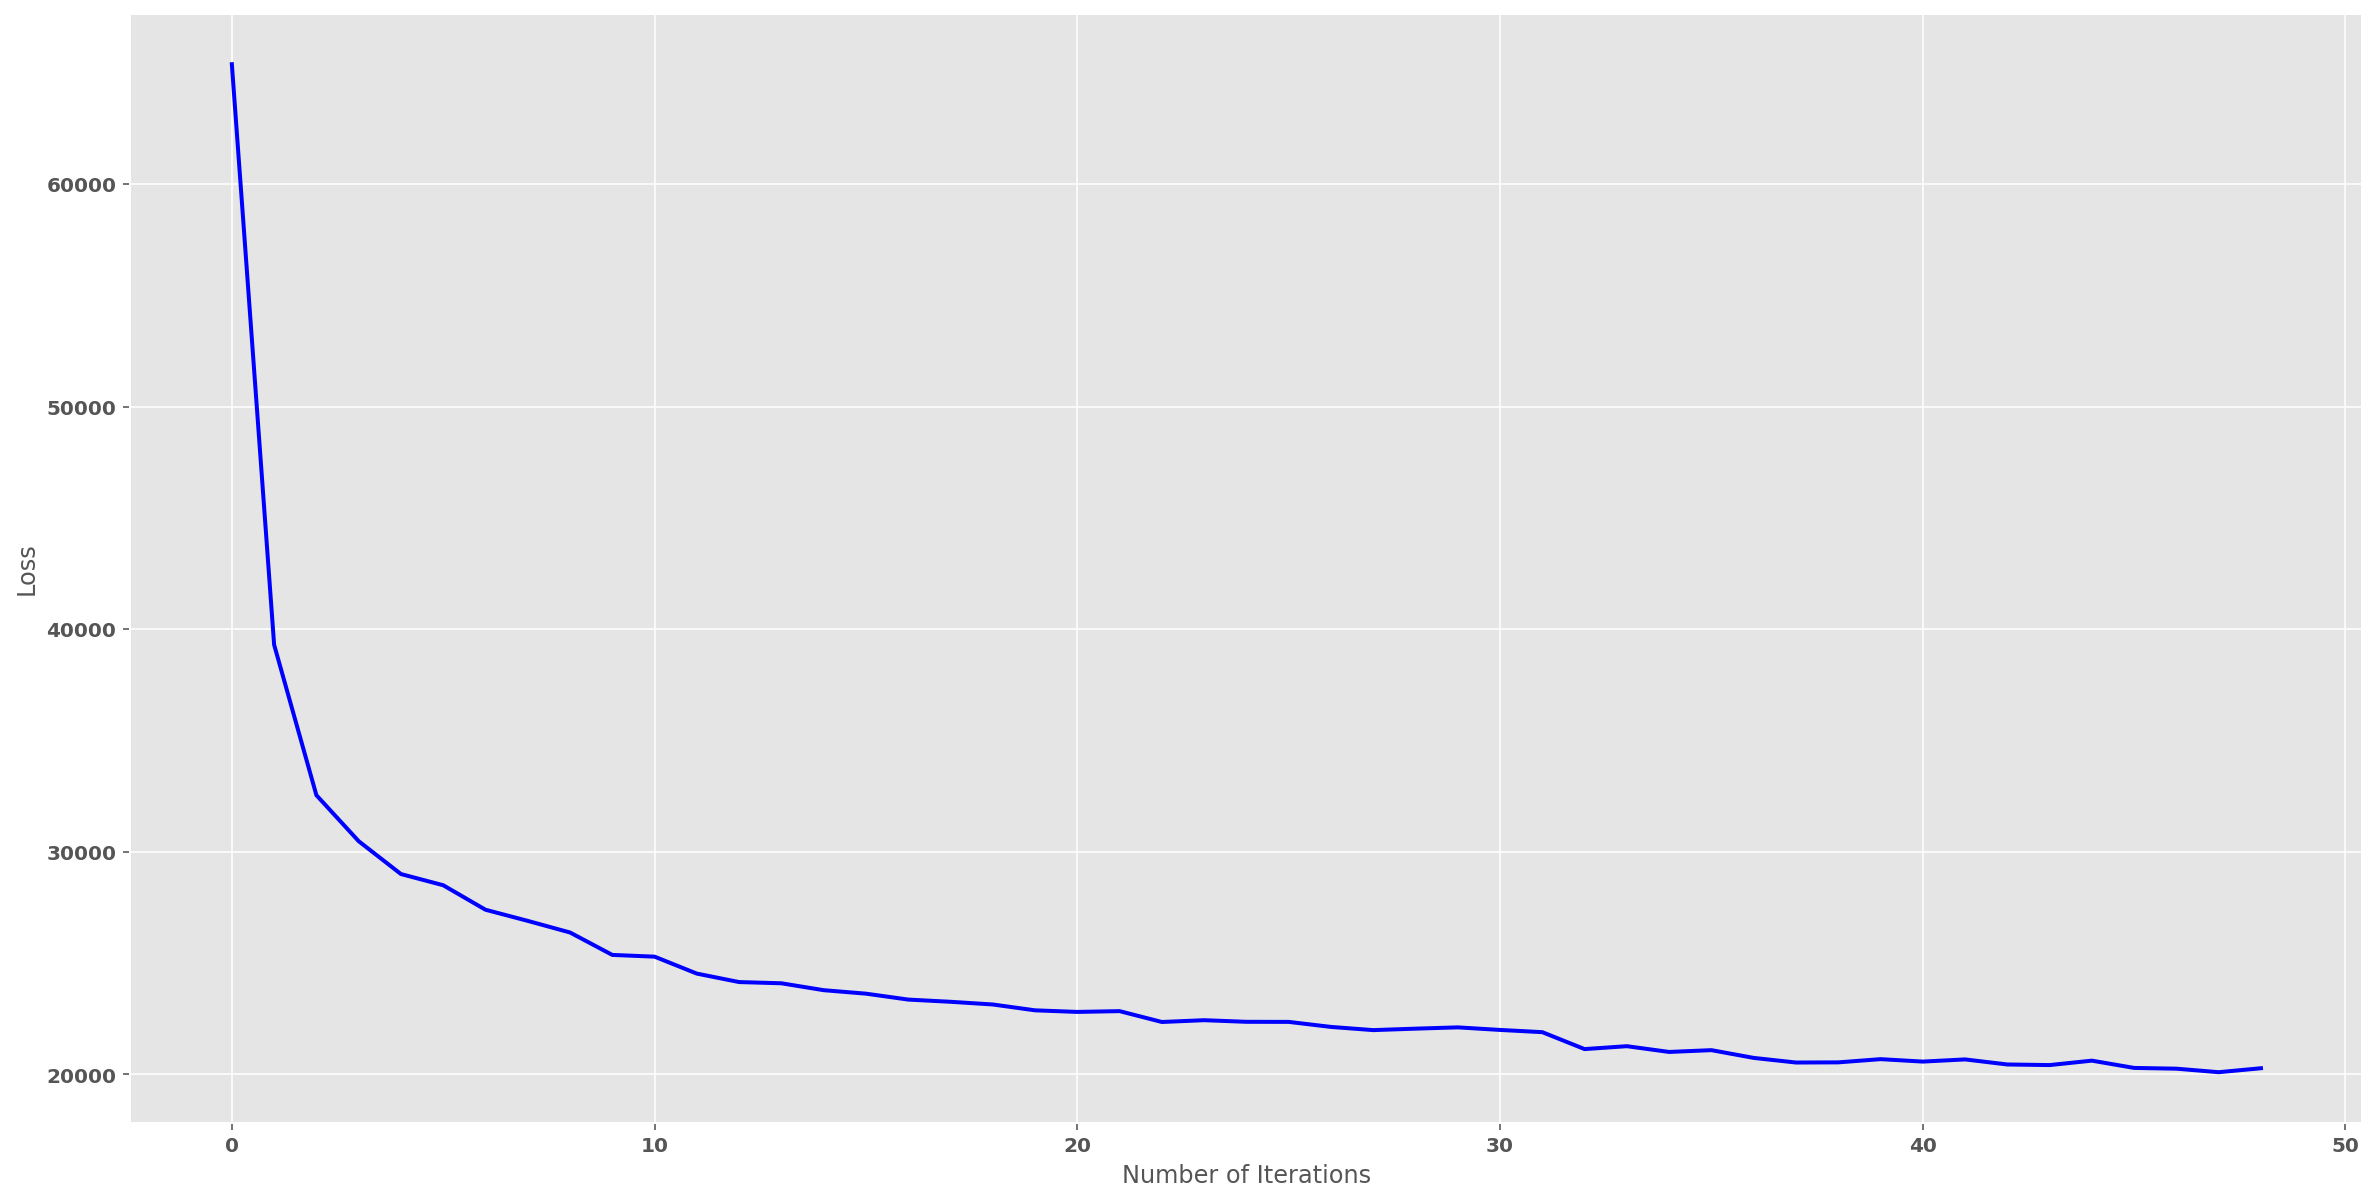

Plotting validation losses


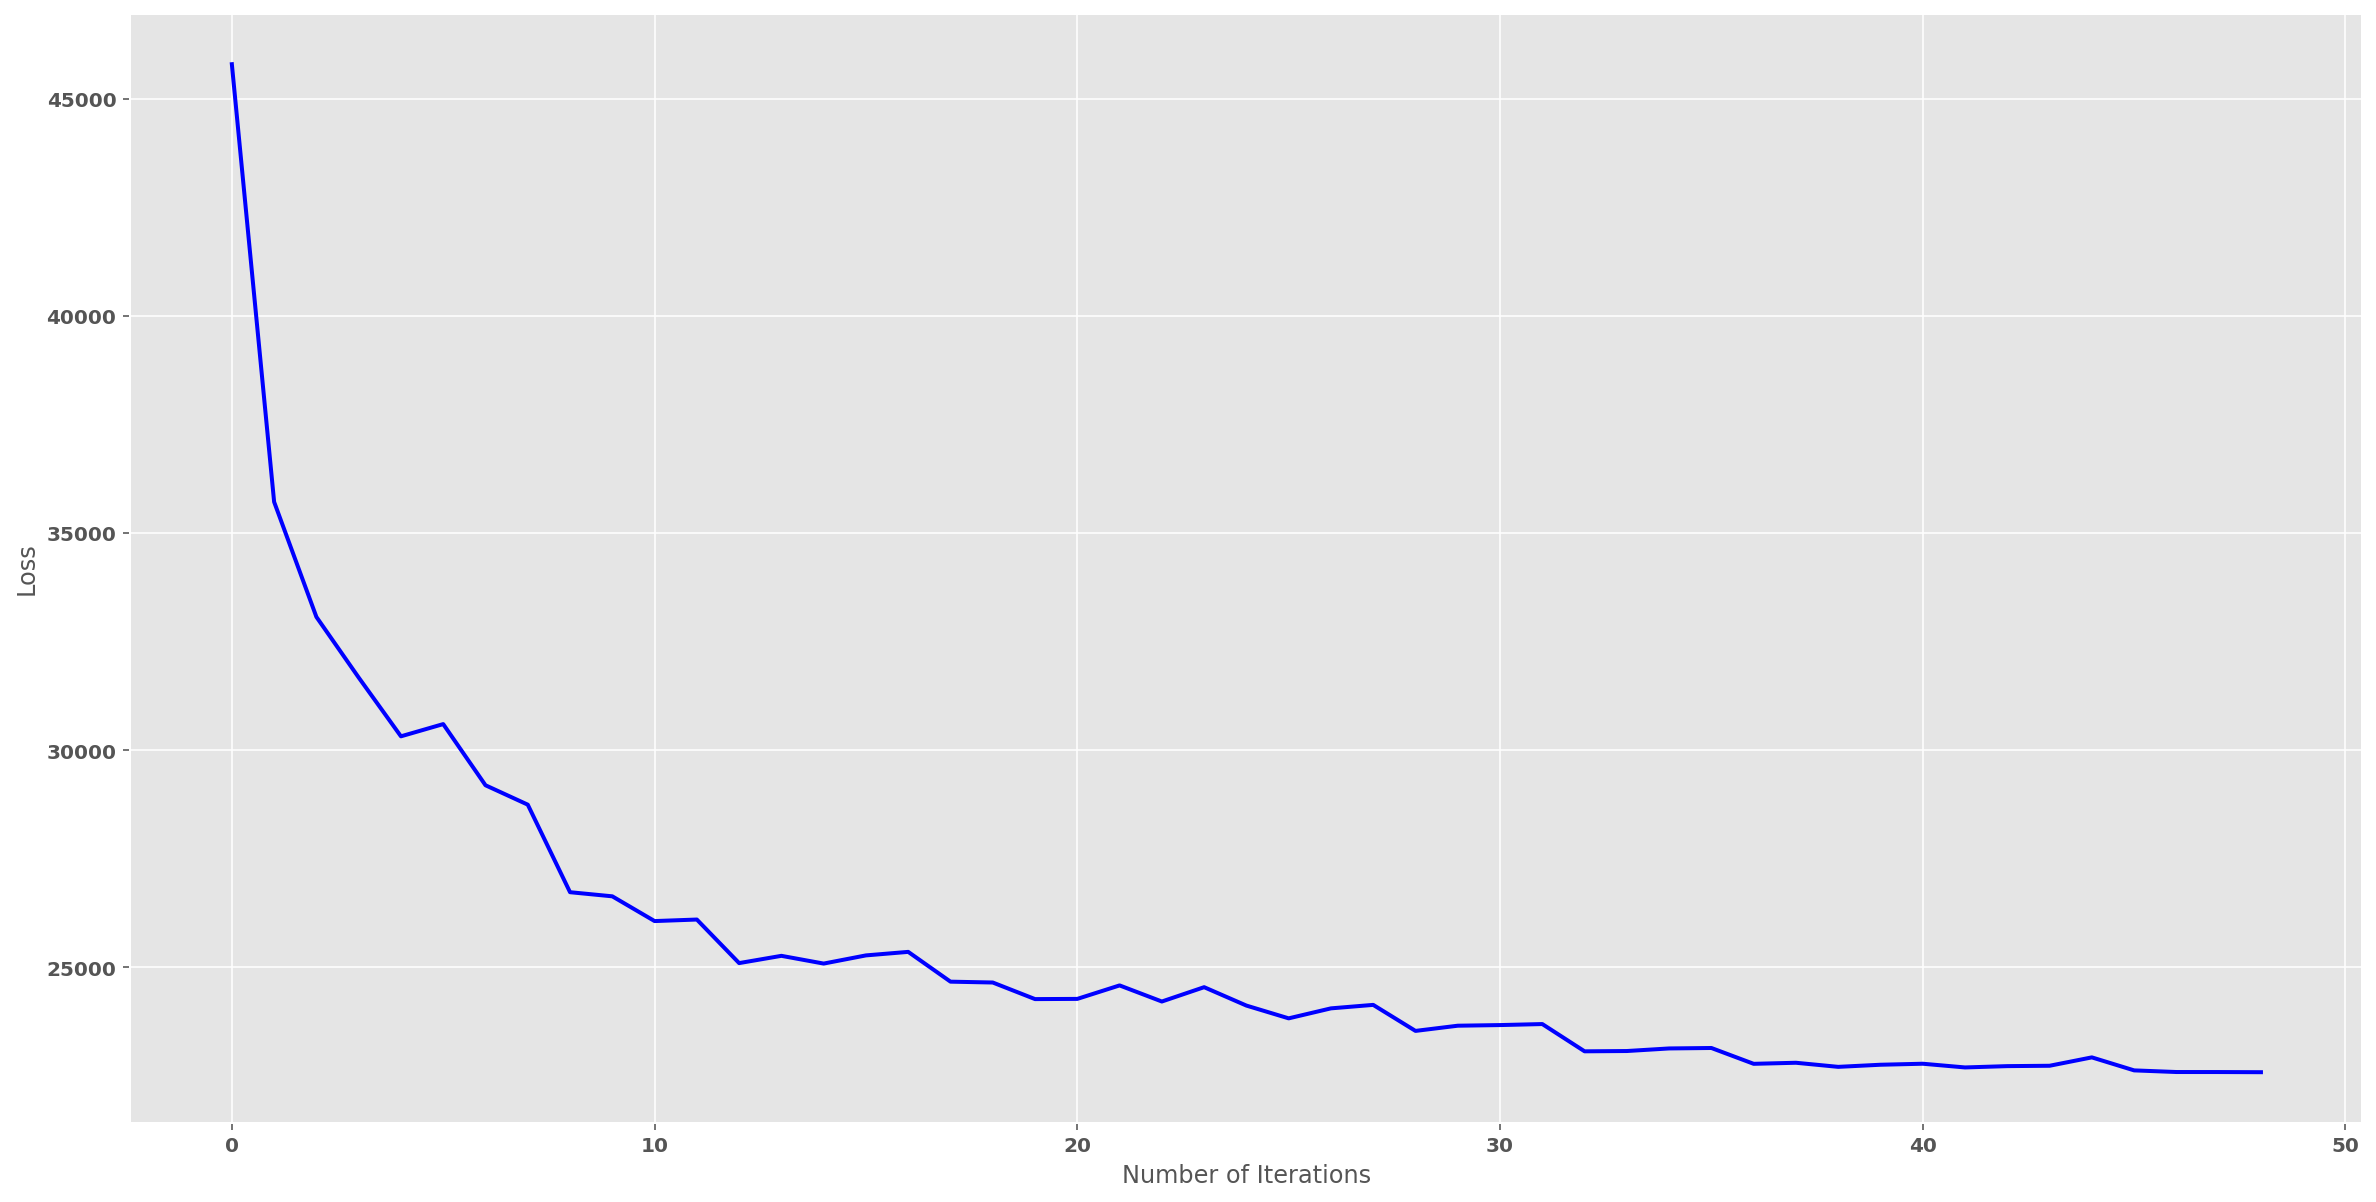

Plotting learning rates


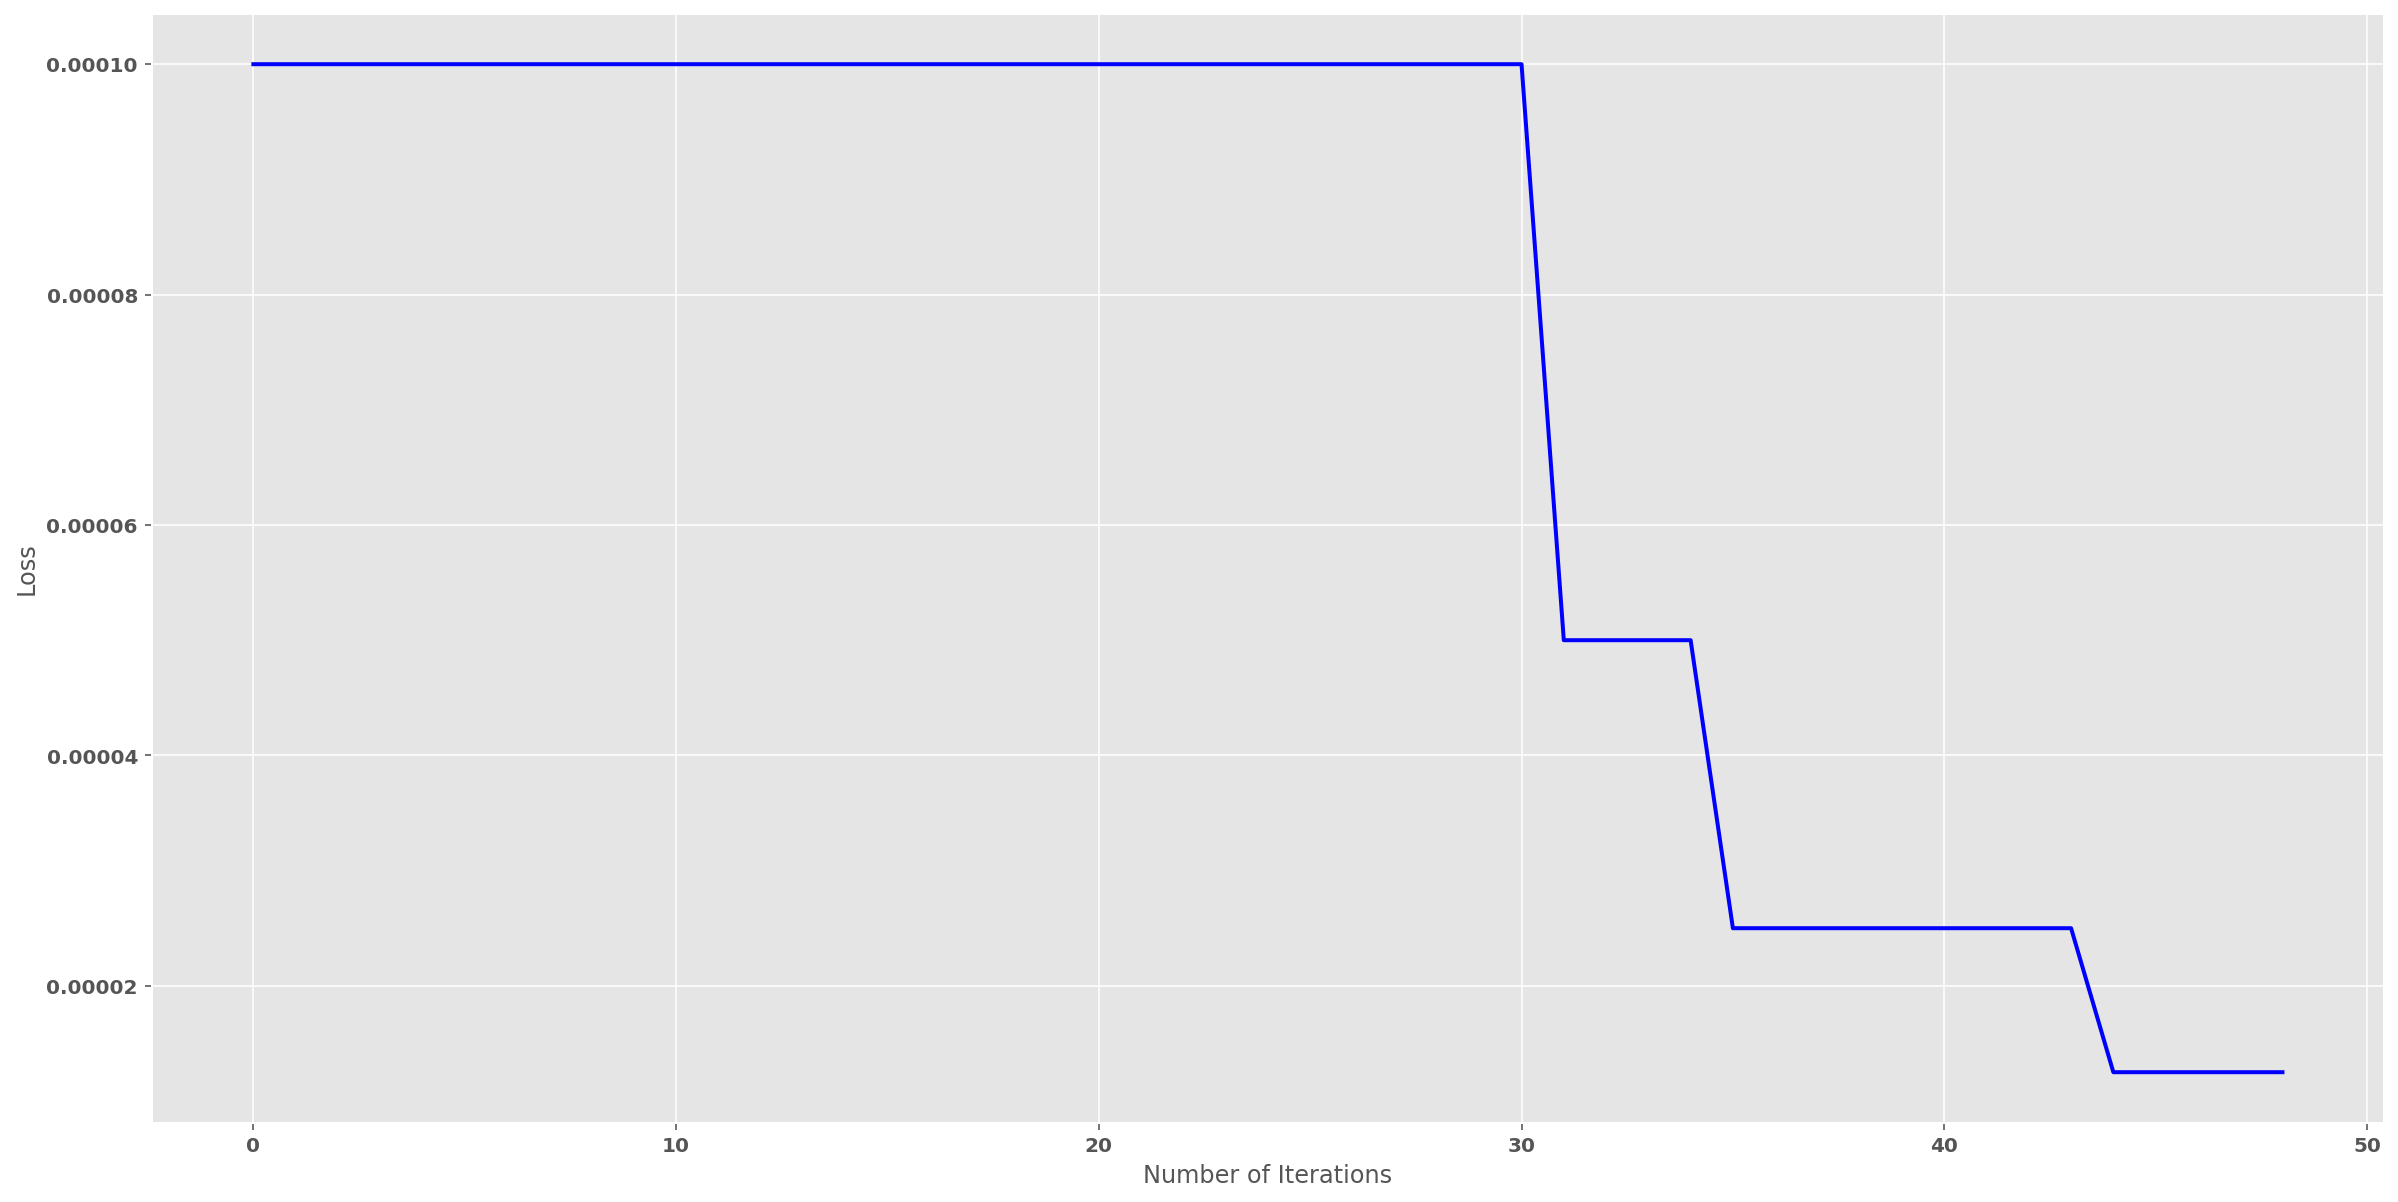

In [12]:
from svlearn.approximator.regression_network import create_plots
print("Plotting training losses")
train_losses = checkpoint['results']['train loss']
create_plots(len(train_losses), train_losses)
print("Plotting validation losses")
val_losses = checkpoint['results']['val loss']
create_plots(len(val_losses), val_losses)
lrs = checkpoint['results']['lr']
print("Plotting learning rates")
create_plots(len(lrs), lrs)

In [13]:

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNetVariationalAutoEncoderModified(
  (encoder): Sequential(
    (0): ResNetEncoder(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): EncoderBottleneckBlock(
        (00 MaxPooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (01 EncoderLayer): EncoderBottleneckLayer(
          (weight_layer1): Sequential(
            (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (weight_layer2): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Visualize the reconstruction (top row being original images and bottom being reconstructed)

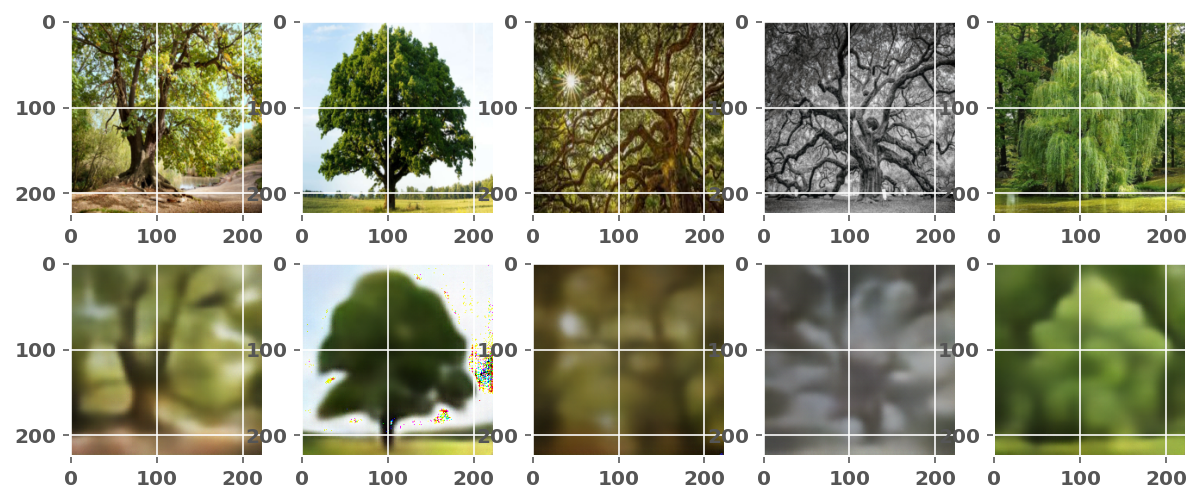

In [14]:
# Create random shuffles of the val loader to visualize different samples each time.
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True) 
# Call this to monitor reconstruction
visualize_reconstruction(model, val_loader, device=device)

Visualize interpolations between the reconstruction of two images

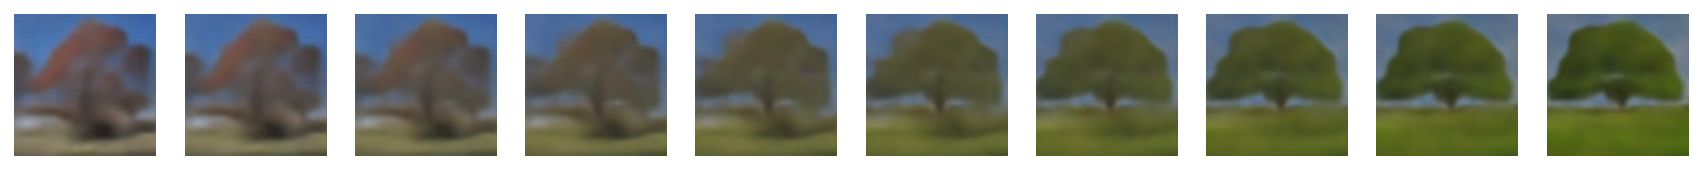

In [15]:

# Create random shuffle of train dataset to pick random 2 images every time.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
first_train_batch, _ = next(iter(train_loader))
# Visualize interpolations
# Assuming image1 and image2 are samples from your dataset (PIL images already transformed to tensor)
image1 = first_train_batch[0]  # First image
image2 = first_train_batch[1]  # Second image

# Visualize interpolation between the two images
visualize_interpolations(model, image1, image2, num_steps=10, is_color=True, device=device)

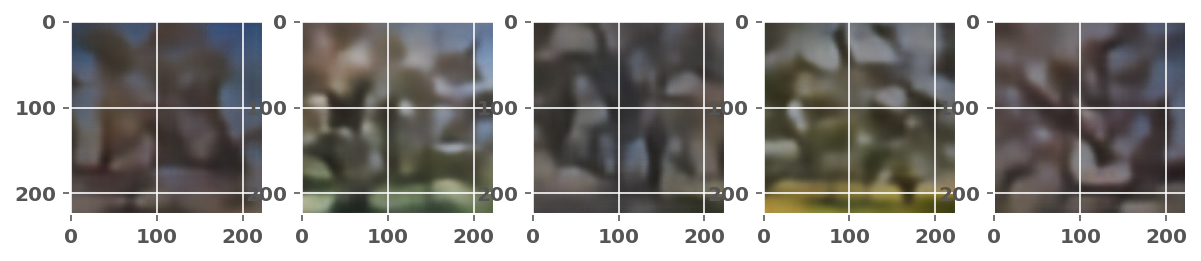

In [16]:
import matplotlib.pyplot as plt
from svlearn.auto_encoders.auto_encoder_util import convert
latent_dim = 128

# Batch size (samples to generate)
batch_size = 5

# Generate a batch of 128-dimensional latent Gaussian normal variables
latent_variables = torch.randn(batch_size, latent_dim)
with torch.no_grad():
    generated_images = model.decoder(latent_variables.to(device))
    # Display original and reconstructed images
    _, axs = plt.subplots(1, 5, figsize=(10, 4))
    for i in range(5):
        axs[i].imshow(convert(generated_images[i].cpu()))
    plt.show()